# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

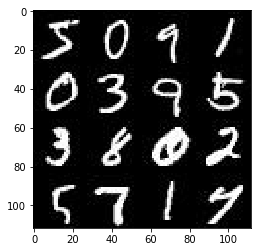

In [5]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

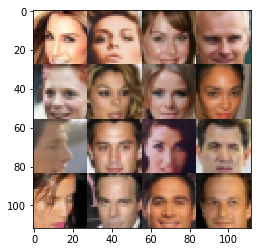

In [6]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


C:\Users\kenneth\Anaconda2\envs\dlnd2\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='l_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        ker_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)
        
        images_layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=ker_initializer)
        images_layer1 = tf.maximum(alpha * images_layer1, images_layer1)
        # 14x14x64
        
        images_layer2 = tf.layers.conv2d(images_layer1, 128, 5, strides=2, padding='same',kernel_initializer=ker_initializer)
        images_layer2 = tf.layers.batch_normalization(images_layer2, training=True)
        images_layer2 = tf.maximum(alpha * images_layer2, images_layer2)
        # 7x7x128
        
        images_layer3 = tf.layers.conv2d(images_layer2, 256, 5, strides=2, padding='same',kernel_initializer=ker_initializer)
        images_layer3 = tf.layers.batch_normalization(images_layer3, training=True)
        images_layer3 = tf.maximum(alpha * images_layer3, images_layer3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(images_layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        images_layer1 = tf.layers.dense(z, 7*7*256)
        images_layer1 = tf.reshape(images_layer1, (-1, 7, 7, 256))
        images_layer1 = tf.layers.batch_normalization(images_layer1, training=is_train)
        images_layer1 = tf.maximum(alpha * images_layer1, images_layer1)
        # 7x7x256
        
        ker_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)
        
        images_layer2 = tf.layers.conv2d_transpose(images_layer1, 128, 5, strides=1, padding='same',kernel_initializer=ker_initializer)
        images_layer2 = tf.layers.batch_normalization(images_layer2, training=is_train)
        images_layer2 = tf.maximum(alpha * images_layer2, images_layer2)
        # 7x7x128
        
        images_layer3 = tf.layers.conv2d_transpose(images_layer2, 64, 5, strides=2, padding='same',kernel_initializer=ker_initializer)
        images_layer3 = tf.layers.batch_normalization(images_layer3, training=is_train)
        images_layer3 = tf.maximum(alpha * images_layer3, images_layer3)
        # 14x14x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(images_layer3, out_channel_dim, 5, strides=2, padding='same',kernel_initializer=ker_initializer)
        # 28x28x3
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _,image_width, image_height, image_channels =data_shape
    input_real, input_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    n_images =16
    print_every=10
    show_every=100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, l_rate: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images, l_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 1.2661
Epoch 1/2... Discriminator Loss: 2.9949... Generator Loss: 0.0701
Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 0.5955
Epoch 1/2... Discriminator Loss: 0.7877... Generator Loss: 0.9652
Epoch 1/2... Discriminator Loss: 0.4281... Generator Loss: 1.6791
Epoch 1/2... Discriminator Loss: 0.4050... Generator Loss: 2.1670
Epoch 1/2... Discriminator Loss: 0.7921... Generator Loss: 0.9196
Epoch 1/2... Discriminator Loss: 0.3467... Generator Loss: 2.8738
Epoch 1/2... Discriminator Loss: 0.4861... Generator Loss: 1.6211
Epoch 1/2... Discriminator Loss: 0.3520... Generator Loss: 2.7560


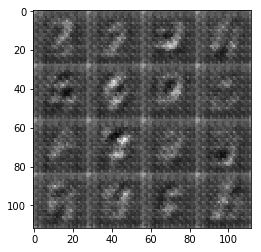

Epoch 1/2... Discriminator Loss: 0.3974... Generator Loss: 2.5421
Epoch 1/2... Discriminator Loss: 0.5672... Generator Loss: 2.4048
Epoch 1/2... Discriminator Loss: 0.5506... Generator Loss: 1.2119
Epoch 1/2... Discriminator Loss: 0.5709... Generator Loss: 1.1756
Epoch 1/2... Discriminator Loss: 1.7509... Generator Loss: 5.0926
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 0.3805... Generator Loss: 1.8209
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 4.0766
Epoch 1/2... Discriminator Loss: 0.3472... Generator Loss: 2.1081
Epoch 1/2... Discriminator Loss: 0.4195... Generator Loss: 1.8534


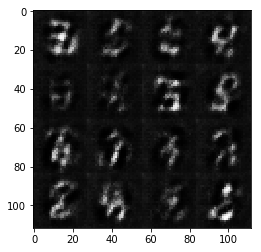

Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 3.9949
Epoch 1/2... Discriminator Loss: 0.7641... Generator Loss: 0.7825
Epoch 1/2... Discriminator Loss: 0.5215... Generator Loss: 2.5237
Epoch 1/2... Discriminator Loss: 0.4149... Generator Loss: 1.6030
Epoch 1/2... Discriminator Loss: 0.4328... Generator Loss: 2.7743
Epoch 1/2... Discriminator Loss: 0.6985... Generator Loss: 3.0460
Epoch 1/2... Discriminator Loss: 0.4789... Generator Loss: 3.0552
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 0.5598... Generator Loss: 2.8060
Epoch 1/2... Discriminator Loss: 0.5712... Generator Loss: 1.1301


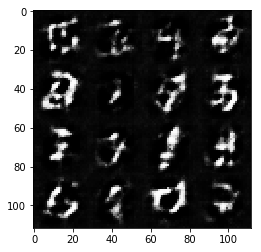

Epoch 1/2... Discriminator Loss: 0.3766... Generator Loss: 1.6806
Epoch 1/2... Discriminator Loss: 0.4075... Generator Loss: 1.8324
Epoch 1/2... Discriminator Loss: 0.4888... Generator Loss: 2.1821
Epoch 1/2... Discriminator Loss: 0.4823... Generator Loss: 2.0708
Epoch 1/2... Discriminator Loss: 0.6906... Generator Loss: 3.4610
Epoch 1/2... Discriminator Loss: 0.4319... Generator Loss: 1.4692
Epoch 1/2... Discriminator Loss: 1.5402... Generator Loss: 4.7881
Epoch 1/2... Discriminator Loss: 0.4005... Generator Loss: 2.0652
Epoch 1/2... Discriminator Loss: 0.6483... Generator Loss: 0.9643
Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 2.0946


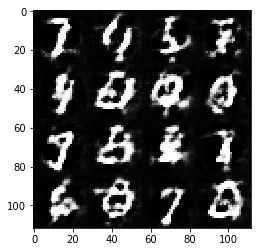

Epoch 1/2... Discriminator Loss: 0.5265... Generator Loss: 1.7512
Epoch 1/2... Discriminator Loss: 0.5469... Generator Loss: 1.2540
Epoch 1/2... Discriminator Loss: 0.5019... Generator Loss: 1.4415
Epoch 1/2... Discriminator Loss: 0.9474... Generator Loss: 0.7146
Epoch 1/2... Discriminator Loss: 0.5568... Generator Loss: 1.4863
Epoch 1/2... Discriminator Loss: 0.8398... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 0.7243... Generator Loss: 2.3247
Epoch 2/2... Discriminator Loss: 0.5189... Generator Loss: 1.3911
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 0.9770


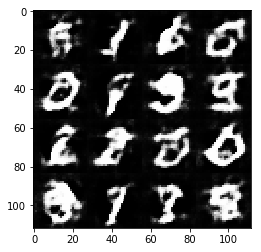

Epoch 2/2... Discriminator Loss: 0.4558... Generator Loss: 2.1432
Epoch 2/2... Discriminator Loss: 1.1573... Generator Loss: 2.6599
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 1.3428
Epoch 2/2... Discriminator Loss: 1.1133... Generator Loss: 0.5458
Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 1.3264
Epoch 2/2... Discriminator Loss: 0.5426... Generator Loss: 1.6001
Epoch 2/2... Discriminator Loss: 0.6117... Generator Loss: 1.2415
Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 2.7808
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 1.1331
Epoch 2/2... Discriminator Loss: 0.6270... Generator Loss: 1.1197


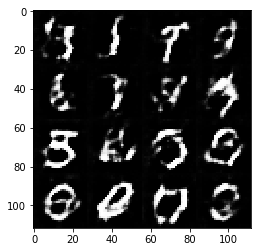

Epoch 2/2... Discriminator Loss: 0.6782... Generator Loss: 1.1315
Epoch 2/2... Discriminator Loss: 0.6903... Generator Loss: 0.9450
Epoch 2/2... Discriminator Loss: 0.8200... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 0.5866... Generator Loss: 1.6269
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 1.1656
Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 1.5317
Epoch 2/2... Discriminator Loss: 0.7664... Generator Loss: 1.2329
Epoch 2/2... Discriminator Loss: 0.6896... Generator Loss: 1.3092
Epoch 2/2... Discriminator Loss: 0.5820... Generator Loss: 1.3522
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 0.5912


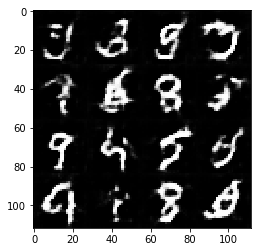

Epoch 2/2... Discriminator Loss: 0.7338... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 2.2136
Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 2.2021
Epoch 2/2... Discriminator Loss: 0.6297... Generator Loss: 1.7223
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 0.5849... Generator Loss: 1.6812
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 0.6959
Epoch 2/2... Discriminator Loss: 0.6678... Generator Loss: 1.3905
Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 1.7908
Epoch 2/2... Discriminator Loss: 0.9426... Generator Loss: 1.8800


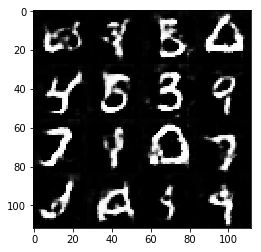

Epoch 2/2... Discriminator Loss: 0.6301... Generator Loss: 1.3004
Epoch 2/2... Discriminator Loss: 0.6765... Generator Loss: 1.5750
Epoch 2/2... Discriminator Loss: 0.5584... Generator Loss: 1.3166
Epoch 2/2... Discriminator Loss: 0.5607... Generator Loss: 1.8200
Epoch 2/2... Discriminator Loss: 0.7194... Generator Loss: 0.8861
Epoch 2/2... Discriminator Loss: 0.7600... Generator Loss: 1.3857
Epoch 2/2... Discriminator Loss: 0.6608... Generator Loss: 1.5461
Epoch 2/2... Discriminator Loss: 0.8922... Generator Loss: 2.2683
Epoch 2/2... Discriminator Loss: 0.5175... Generator Loss: 1.9784
Epoch 2/2... Discriminator Loss: 1.2082... Generator Loss: 0.4844


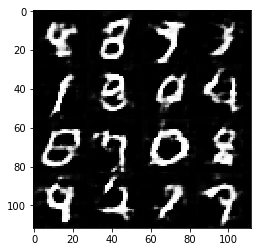

Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 0.6485... Generator Loss: 1.4656
Epoch 2/2... Discriminator Loss: 0.5418... Generator Loss: 1.2660


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 0.3255... Generator Loss: 1.7185
Epoch 1/1... Discriminator Loss: 0.1693... Generator Loss: 5.1581
Epoch 1/1... Discriminator Loss: 0.2936... Generator Loss: 5.4236
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 2.1717
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 1.7208
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 1.9419


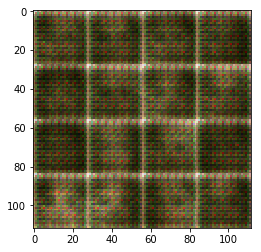

Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 2.0695
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 0.6359... Generator Loss: 1.2994
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 1.5025
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 3.9743
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 0.7872


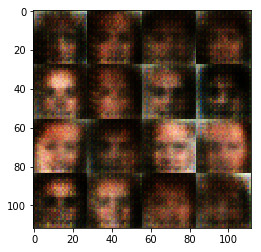

Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 3.6095
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 2.0070
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.3639
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 3.3797
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.3714


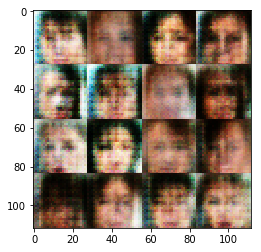

Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.2951
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 2.1153
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 1.6640
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 1.6188
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.4961


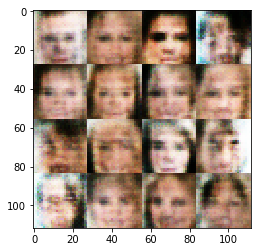

Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 1.8096
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 1.2108
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 1.7152
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.1217
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.8036


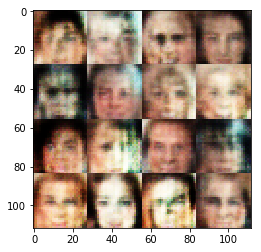

Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.6526... Generator Loss: 2.3740
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 1.6014


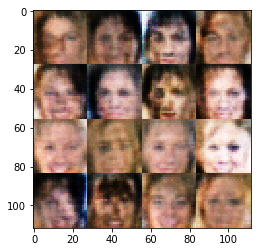

Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 1.5937
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 1.6620
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 1.2397


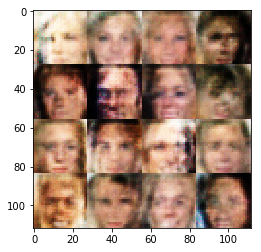

Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 1.3966
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.0526


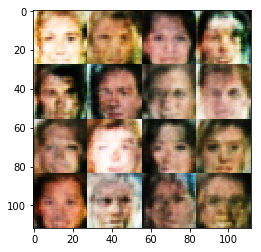

Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 1.6908
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.8377... Generator Loss: 0.2271
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 1.0849


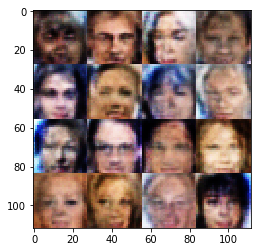

Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.7969


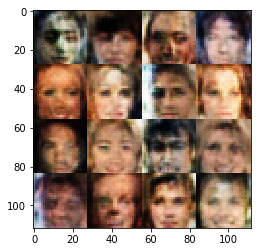

Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 0.9540


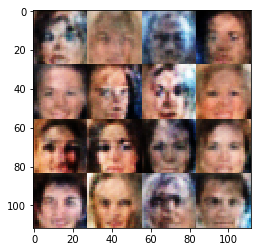

Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.8234
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.2492
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 1.5477


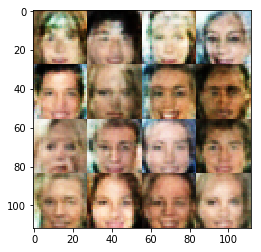

Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.4480
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.3431
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.5428
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.0289


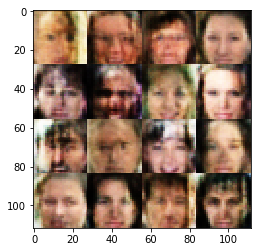

Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 1.4135
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 1.3765
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.3418


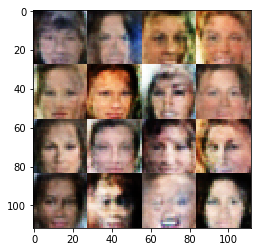

Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.4605
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 0.9756


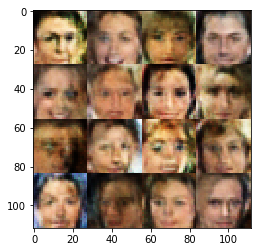

Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.5836
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.6686


In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.